In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('neo_v2.csv')
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [2]:
list(df['orbiting_body'].unique())

['Earth']

In [3]:
list(df['sentry_object'].unique())

[False]

In [4]:
df = df.drop(columns=['id', 'orbiting_body', 'name', 'sentry_object'])

In [5]:
df['hazardous'] = df['hazardous'].astype(int)

In [6]:
unique_values = df['hazardous'].value_counts()/len(df)
print(unique_values)

hazardous
0    0.902682
1    0.097318
Name: count, dtype: float64


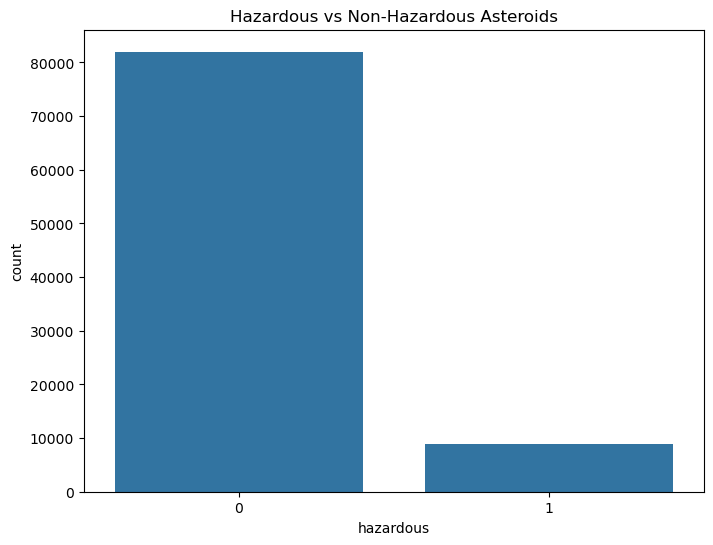

In [7]:
plt.figure(figsize=(8,6))
sns.countplot(df, x='hazardous')
plt.title('Hazardous vs Non-Hazardous Asteroids')
plt.show()

In [8]:
df.describe()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
count,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000,90836.000000
mean,0.127432,0.284947,48066.918918,3.706655e+07,23.527103,0.097318
std,0.298511,0.667491,25293.296961,2.235204e+07,2.894086,0.296392
min,0.000609,0.001362,203.346433,6.745533e+03,9.230000,0.000000
25%,0.019256,0.043057,28619.020645,1.721082e+07,21.340000,0.000000
50%,0.048368,0.108153,44190.117890,3.784658e+07,23.700000,0.000000
75%,0.143402,0.320656,62923.604633,5.654900e+07,25.700000,0.000000
max,37.892650,84.730541,236990.128088,7.479865e+07,33.200000,1.000000


In [9]:
scaler = StandardScaler()
numeric_cols = ['est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance', 'absolute_magnitude']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   est_diameter_min    90836 non-null  float64
 1   est_diameter_max    90836 non-null  float64
 2   relative_velocity   90836 non-null  float64
 3   miss_distance       90836 non-null  float64
 4   absolute_magnitude  90836 non-null  float64
 5   hazardous           90836 non-null  int32  
dtypes: float64(5), int32(1)
memory usage: 3.8 MB


In [11]:
df.isna().sum()

est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
absolute_magnitude    0
hazardous             0
dtype: int64

In [12]:
df.describe()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
count,9.083600e+04,9.083600e+04,9.083600e+04,9.083600e+04,9.083600e+04,90836.000000
mean,-6.070073e-17,9.026887e-17,-1.742017e-16,-1.239046e-16,4.552555e-16,0.097318
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,0.296392
min,-4.248547e-01,-4.248547e-01,-1.892353e+00,-1.658014e+00,-4.940138e+00,0.000000
25%,-3.623890e-01,-3.623890e-01,-7.688996e-01,-8.883231e-01,-7.557190e-01,0.000000
50%,-2.648640e-01,-2.648640e-01,-1.532747e-01,3.489782e-02,5.974166e-02,0.000000
75%,5.349850e-02,5.349850e-02,5.873796e-01,8.716232e-01,7.508101e-01,0.000000
max,1.265126e+02,1.265126e+02,7.469341e+00,1.688093e+00,3.342317e+00,1.000000


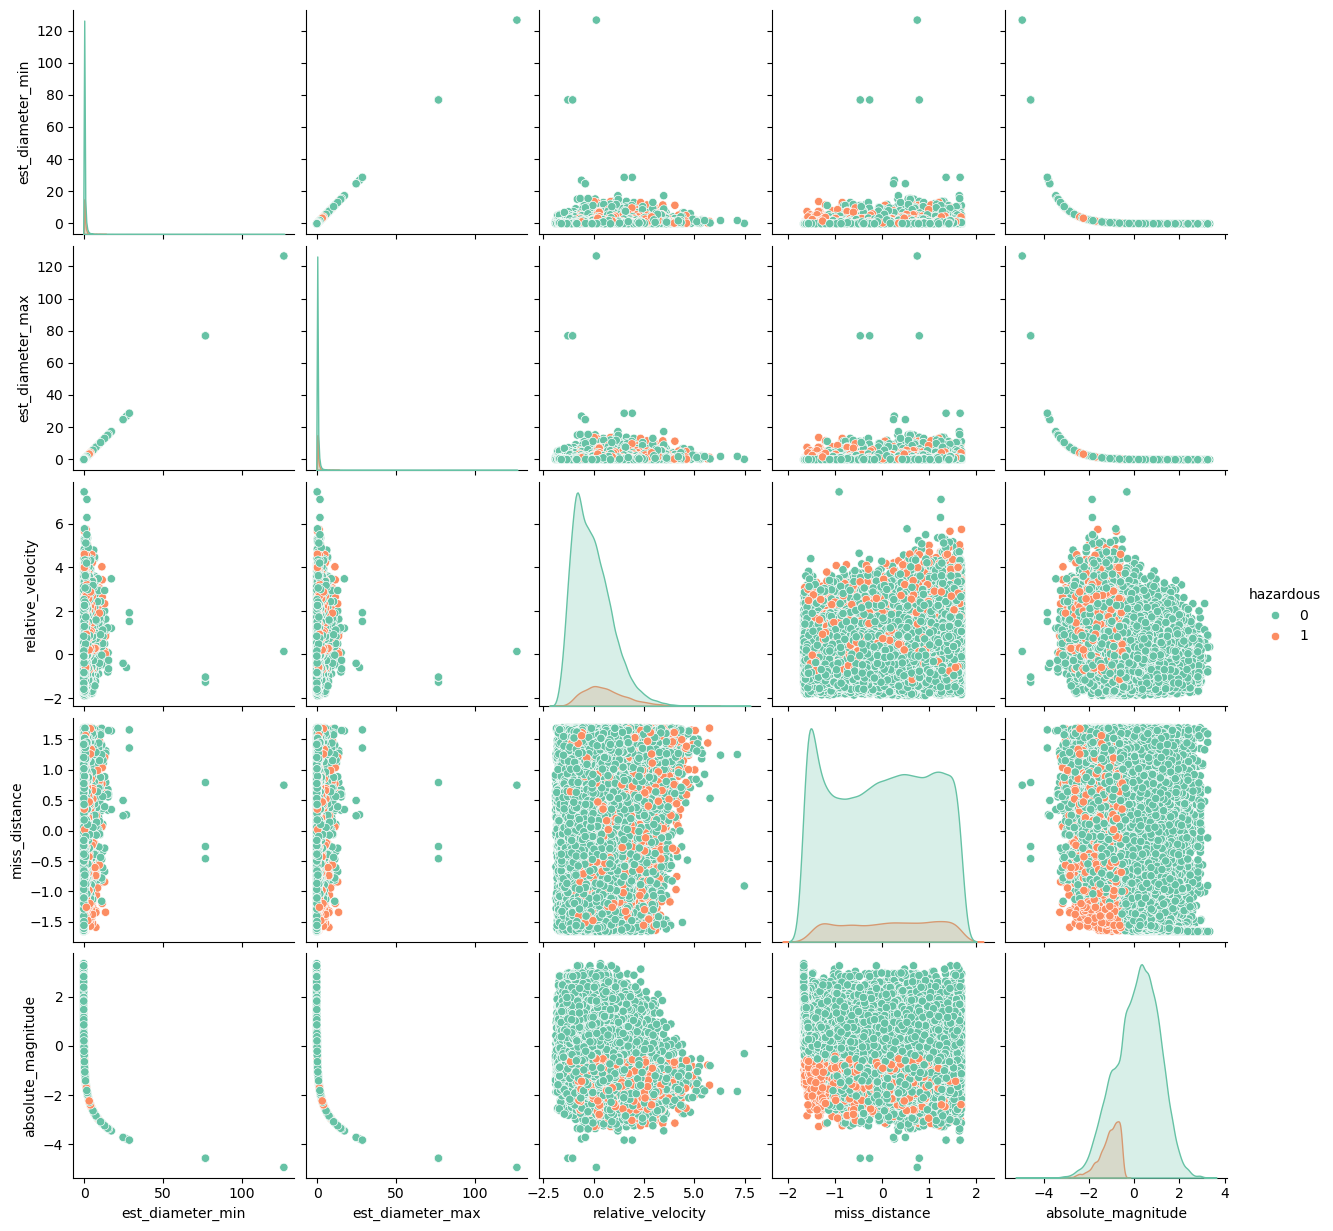

In [11]:
sns.pairplot(df, hue='hazardous', palette='Set2')
plt.show()

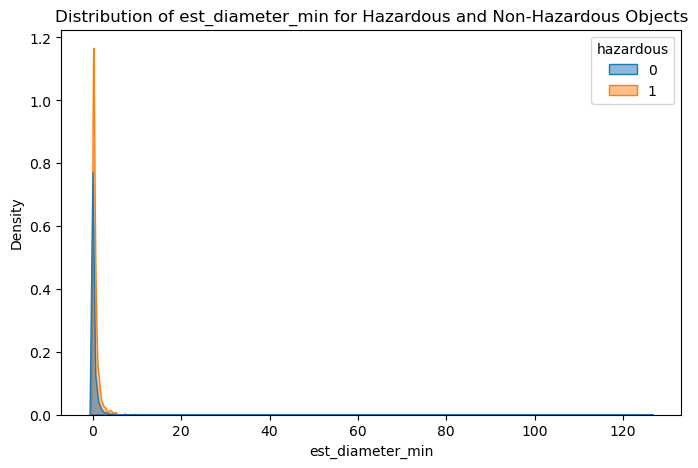

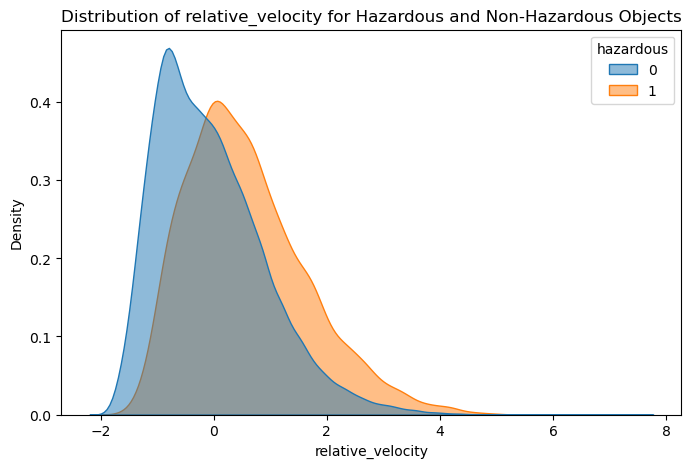

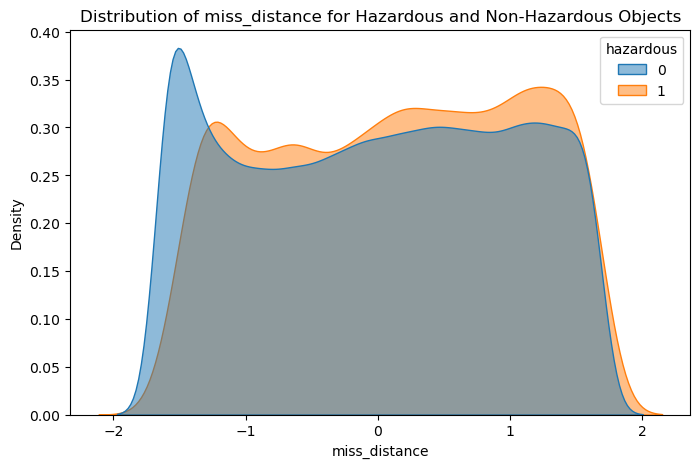

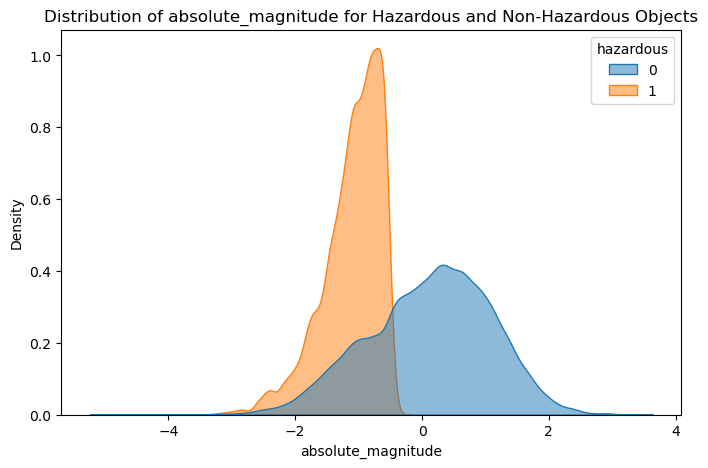

In [12]:
for col in ['est_diameter_min', 'relative_velocity', 'miss_distance', 'absolute_magnitude']:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=df, x=col, hue='hazardous', fill=True, common_norm=False, alpha=0.5)
    plt.title(f'Distribution of {col} for Hazardous and Non-Hazardous Objects')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.show()

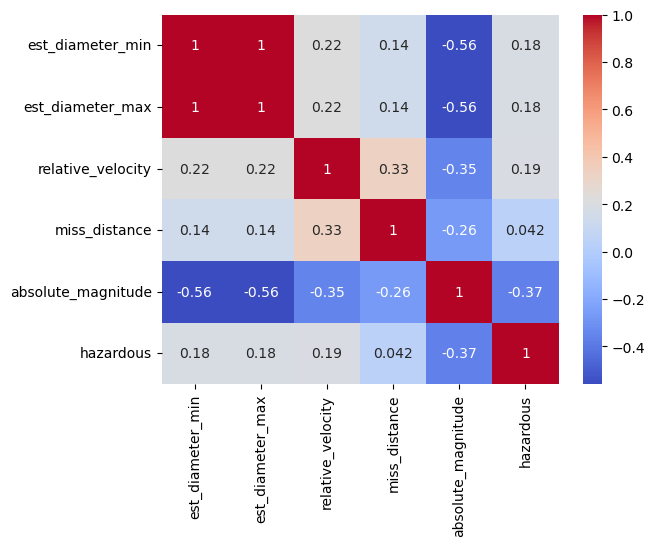

In [13]:
sns.heatmap(df.corr(), annot = True, cmap='coolwarm')
plt.show()

In [13]:
X = df.drop(columns=['hazardous'])
y = df['hazardous']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"X with Smote shape: {X_train_smote.shape}, original X shape: {X_train.shape}")
print(f"y with Smote shape: {y_train_smote.shape}, original y shape: {y_train.shape}")

X with Smote shape: (131114, 5), original X shape: (72668, 5)
y with Smote shape: (131114,), original y shape: (72668,)


In [15]:
def train_evaluate(model, X_train, X_test, y_train, y_test, model_name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{model_name}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,cmap='Blues', display_labels=['Non-Hazardous', 'Hazardous'])
    plt.title(model_name)
    plt.show()

Logistic Regression
[[16292   147]
 [ 1574   155]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     16439
           1       0.51      0.09      0.15      1729

    accuracy                           0.91     18168
   macro avg       0.71      0.54      0.55     18168
weighted avg       0.87      0.91      0.87     18168



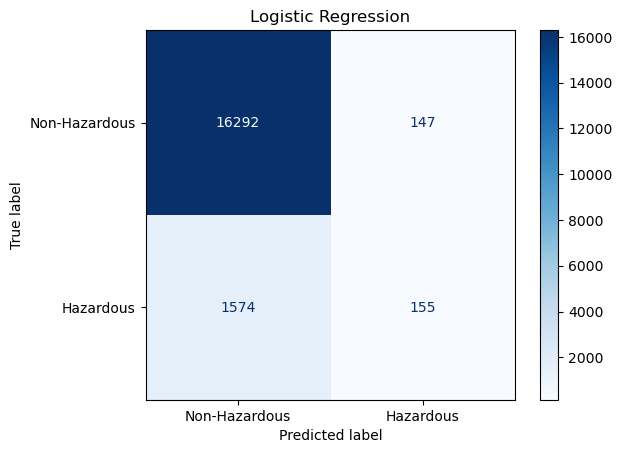

Logistic Regression + SMOTE
[[12612  3827]
 [  126  1603]]
              precision    recall  f1-score   support

           0       0.99      0.77      0.86     16439
           1       0.30      0.93      0.45      1729

    accuracy                           0.78     18168
   macro avg       0.64      0.85      0.66     18168
weighted avg       0.92      0.78      0.82     18168



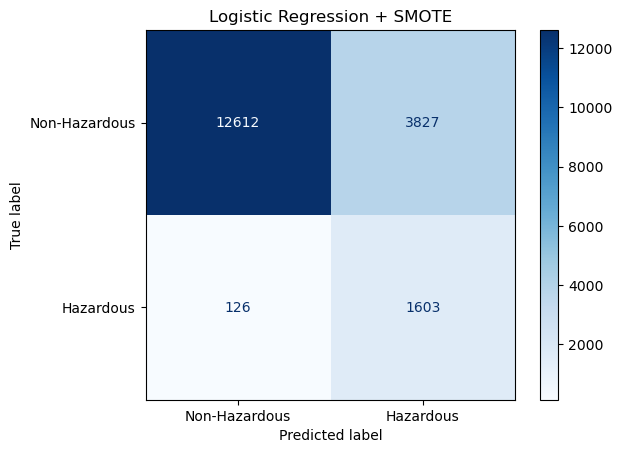

In [20]:
model_lr = LogisticRegression()
train_evaluate(model_lr, X_train, X_test, y_train, y_test, "Logistic Regression")
train_evaluate(model_lr, X_train_smote, X_test, y_train_smote, y_test, "Logistic Regression + SMOTE")

SVM
[[16377    62]
 [ 1525   204]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     16439
           1       0.77      0.12      0.20      1729

    accuracy                           0.91     18168
   macro avg       0.84      0.56      0.58     18168
weighted avg       0.90      0.91      0.88     18168



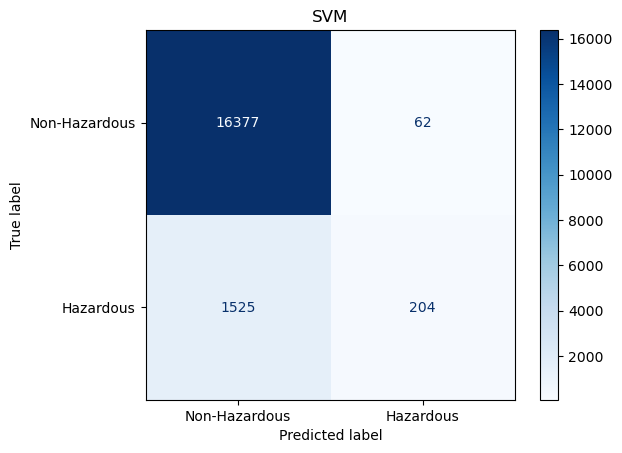

In [ ]:
model_svm = svm.SVC(kernel='rbf')
train_evaluate(model_svm, X_train, X_test, y_train, y_test, "SVM")
train_evaluate(model_svm, X_train_smote, X_test, y_train_smote, y_test, "SVM + SMOTE")

XGBoost
[[16235   204]
 [ 1313   416]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     16439
           1       0.67      0.24      0.35      1729

    accuracy                           0.92     18168
   macro avg       0.80      0.61      0.65     18168
weighted avg       0.90      0.92      0.90     18168



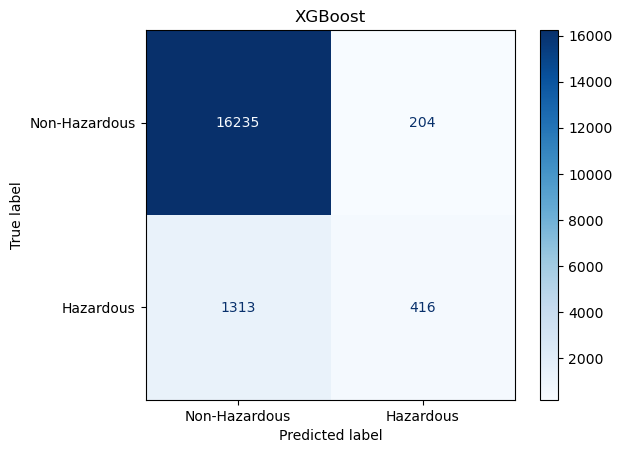

XGboost + SMOTE
[[13987  2452]
 [  360  1369]]
              precision    recall  f1-score   support

           0       0.97      0.85      0.91     16439
           1       0.36      0.79      0.49      1729

    accuracy                           0.85     18168
   macro avg       0.67      0.82      0.70     18168
weighted avg       0.92      0.85      0.87     18168



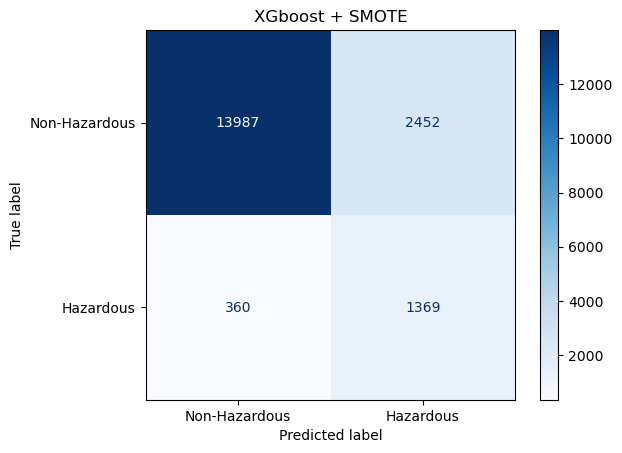

In [21]:
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
train_evaluate(model_xgb, X_train, X_test, y_train, y_test, "XGBoost")
train_evaluate(model_xgb, X_train_smote, X_test, y_train_smote, y_test, "XGboost + SMOTE")

Random Forest
[[15994   445]
 [  980   749]]
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     16439
           1       0.63      0.43      0.51      1729

    accuracy                           0.92     18168
   macro avg       0.78      0.70      0.73     18168
weighted avg       0.91      0.92      0.92     18168



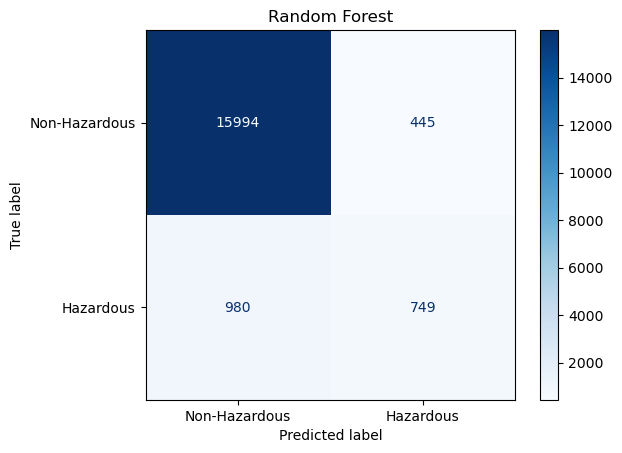

Random Forest + SMOTE
[[15411  1028]
 [  687  1042]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     16439
           1       0.50      0.60      0.55      1729

    accuracy                           0.91     18168
   macro avg       0.73      0.77      0.75     18168
weighted avg       0.91      0.91      0.91     18168



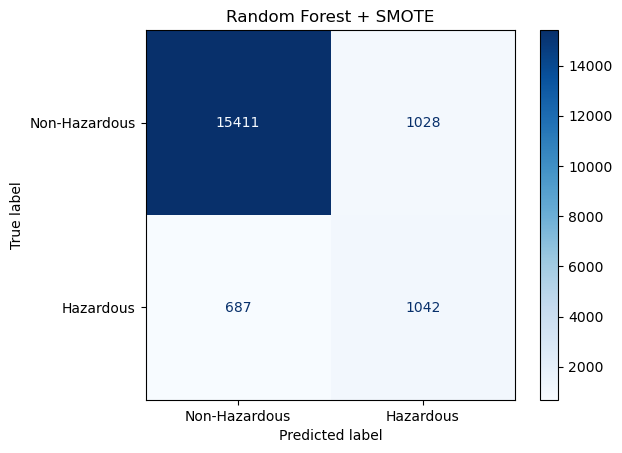

In [16]:
model_rf = RandomForestClassifier()
train_evaluate(model_rf, X_train, X_test, y_train, y_test, "Random Forest")
train_evaluate(model_rf, X_train_smote, X_test, y_train_smote, y_test, "Random Forest + SMOTE")

KNN
[[16235   204]
 [ 1313   416]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     16439
           1       0.67      0.24      0.35      1729

    accuracy                           0.92     18168
   macro avg       0.80      0.61      0.65     18168
weighted avg       0.90      0.92      0.90     18168



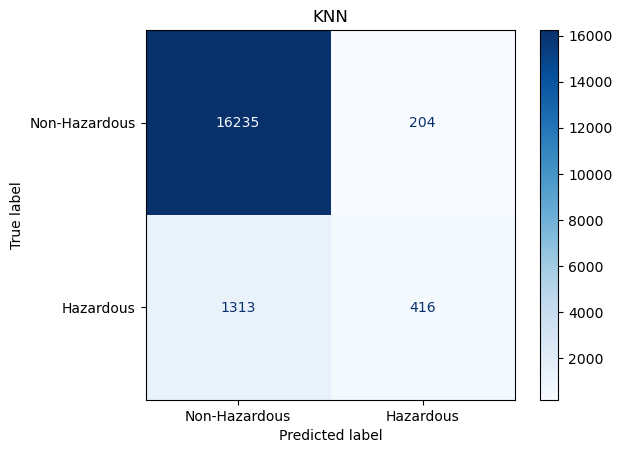

KNN + SMOTE
[[13987  2452]
 [  360  1369]]
              precision    recall  f1-score   support

           0       0.97      0.85      0.91     16439
           1       0.36      0.79      0.49      1729

    accuracy                           0.85     18168
   macro avg       0.67      0.82      0.70     18168
weighted avg       0.92      0.85      0.87     18168



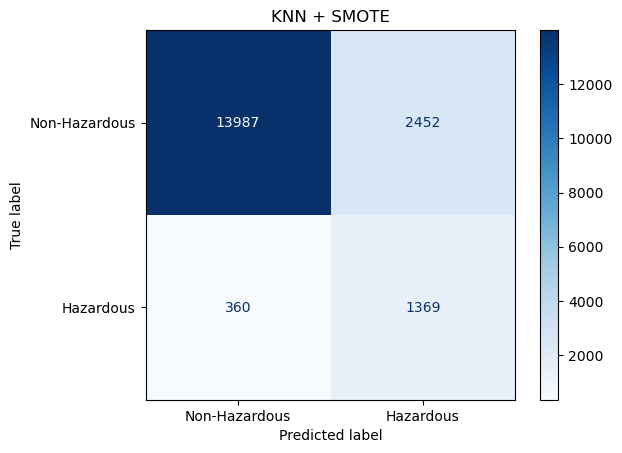

In [ ]:
model_knn = KNeighborsClassifier(n_neighbors=5)
train_evaluate(model_xgb, X_train, X_test, y_train, y_test, "KNN")
train_evaluate(model_xgb, X_train_smote, X_test, y_train_smote, y_test, "KNN + SMOTE")

In [ ]:
# Random Forest seems to be the best model in this case. 
# After model selection, the next step is to identify best parameters:

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}

model_rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=2)
grid_rf.fit(X_train_smote, y_train_smote)

print("Best Random Forest params:", grid_rf.best_params_)

best_params_rf = grid_rf.best_params_
best_model_rf = RandomForestClassifier(**best_params_rf)
best_model_rf.fit(X_train_smote, y_train_smote)
y_pred_rf = best_model_rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Random Forest params: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Accuracy: 0.9063188022897402
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95     16439
           1       0.51      0.60      0.55      1729

    accuracy                           0.91     18168
   macro avg       0.73      0.77      0.75     18168
weighted avg       0.91      0.91      0.91     18168



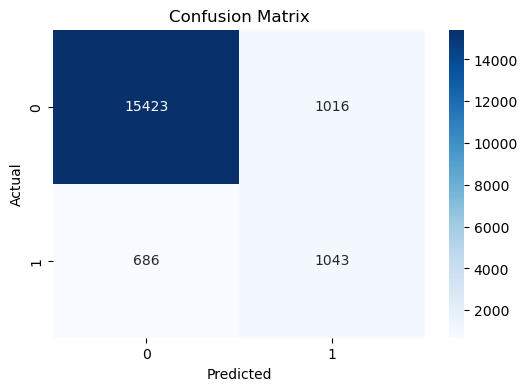

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}

rfc = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=param_grid,
                                   n_iter=30,
                                   cv=3,
                                   n_jobs=-1,
                                   verbose=2,
                                   scoring='accuracy',
                                   random_state=42)

random_search.fit(X_train_smote, y_train_smote)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()